In [2]:
# Essential Libraries
import cv2
import pandas as pd
import matplotlib.pyplot as plt

#import av   # !pip install av
import numpy as np
import os
import torch
from transformers import VivitConfig, VivitModel, VivitImageProcessor
from torchvision.transforms import Compose, Resize, Lambda, ToTensor, ToPILImage
from PIL import Image

# Display plots inline
%matplotlib inline

# Set plot parameters
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams['axes.grid'] = False
plt.style.use('dark_background')
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["font.size"] = 15
#VID-20230703-WA0028_ beginning-cut and mid-cut

# Prepare videos for read in with VideoVit

In [ ]:
# import av   # !pip install av

# fpath = "/Users/mikehemberger/Documents/vscode/totems/totem-prototype/videos/MVI_7423_pulse_wabbern-cropped/"
# vid_filename = "MVI_7423_pulse_wabbern-cropped.mp4"
#container = av.open(os.path.join(fpath, vid_filename))

#for frame in container.decode(video=0):
#    frame.to_image().save(fpath + 'images-from-av/frame-%04d.jpg' % frame.index)

In [ ]:
#model = AutoModel.from_pretrained("bert-base-cased")
#configuration = VivitConfig()
#model = VivitModel(configuration)
#configuration = model.config


def read_video_pyav(container):
    frames = []
    for frame in container.decode(video=0):
        frames.append(frame.to_ndarray(format="rgb24"))
    return frames

def process_frames(model, processor, frames):
    inputs = processor(frames, return_tensors="pt")
    outputs = model(**inputs)
    return outputs

# Initialize model and processor
#image_processor = VivitImageProcessor.from_pretrained("google/vivit-b-16x2")
#model = VivitModel.from_pretrained("google/vivit-b-16x2")

# Use a pipeline as a high-level helper
# from transformers import pipeline
# pipe = pipeline(model="google/vivit-b-16x2", task="feature-extraction")
# from transformers import AutoTokenizer, ViViTForVideoClassification

# tokenizer = AutoTokenizer.from_pretrained("google/vivit-b-16x2")
# model = ViViTForVideoClassification.from_pretrained("google/vivit-b-16x2")

# image_processor = VivitImageProcessor.from_pretrained("google/vivit-b-16x2")

# model = VivitForVideoClassification.from_pretrained("google/vivit-b-16x2")

# inputs = image_processor(list(video), return_tensors="pt")

# with torch.no_grad():
#     outputs = pipe(**inputs)
#     #outputs = model(**inputs)


print(model.config.num_frames)

# Open video file
fpath = "/Users/mikehemberger/Documents/vscode/totems/totem-prototype/videos/MVI_7423_pulse_wabbern-cropped/"
vid_filename = "MVI_7423_pulse_wabbern-cropped.mp4"
container = av.open(os.path.join(fpath, vid_filename))

# Read video frames
video = read_video_pyav(container)


# Load your model
#model = VivitModel.from_pretrained("google/vivit-b-16x2")
model.config.num_frames = 32
num_frames_expected = model.config.num_frames  # replace this with actual value if not found in config

# Define the frame processing function
def process_frames(model, processor, frames):
    inputs = processor(frames, return_tensors="pt")
    outputs = model(**inputs)
    return outputs

transform = Compose([
    ToPILImage(),  # Convert tensor to PIL Image directly
    Resize((224, 224)),  # Resize frames to the size your model expects
    ToTensor()  # Convert frames to PyTorch tensors
])

# Apply transformation to all frames
video = [transform(frame) for frame in video]
feature_vectors = []
num_frames_per_input = model.config.num_frames  # adjust as necessary

#for i in range(0, len(video), num_frames_per_input):
for i in range(0, num_frames_per_input*2, num_frames_per_input):
    frames_batch = video[i : i+num_frames_per_input]

    # if not enough frames for a full batch, pad with zeros
    if len(frames_batch) < num_frames_per_input:
        padding = [torch.zeros((3, 224, 224)) for _ in range(num_frames_per_input - len(frames_batch))]
        frames_batch.extend(padding)

    frames_batch = torch.stack(frames_batch)  # Combine frames into a tensor
    frames_batch = frames_batch.unsqueeze(0)  # Add an extra batch dimension
    print(frames_batch.shape)
    inputs = {'pixel_values': frames_batch}
    outputs = model(**inputs)
    feature_vectors.append(np.squeeze(outputs.last_hidden_state.detach().cpu().numpy()))


In [ ]:
[np.squeeze(f).shape for f in feature_vectors]
#feature_vectors[0].shape

In [ ]:
fvs = np.array(np.squeeze(feature_vectors[0]))
print(fvs.shape)

fvs = np.array([np.squeeze(f) for f in feature_vectors])  # or concate
print(fvs.shape)

#np.save(f"./totem-prototype/videos/MVI_7423_pulse_wabbern-cropped/vivit_feature_vectors_224.npy", fvs)


In [8]:
#fvs = np.load(f"./totem-prototype/videos/MVI_7423_pulse_wabbern-cropped/vivit_feature_vectors_224.npy")
fvs = np.load(f"../totems/totem-prototype/videos/MVI_7423_pulse_wabbern-cropped/images-224/prototypev1-fv-MVI_7423_pulse_wabbern-cropped-224.npy")  # vivit?!

fvs.shape

(805, 768)

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN

# from sklearn.decomposition import PCA
# pca = PCA(n_components=500)
# pca_result = pca.fit_transform(fv)
# print(pca_result.shape)
# print('Explained variation per principal component: {}'.format(
#     pca.explained_variance_ratio_.sum()))


tsne = TSNE(n_components=2, perplexity=45, early_exaggeration=250, learning_rate=45, random_state=42, init="pca")
features_embedded = tsne.fit_transform(fvs)
#features_embedded = tsne.fit_transform(pca_result)
#db = DBSCAN(eps=5.75, min_samples=50).fit(features_embedded)  # You can adjust eps and min_samples
#clusters = db.labels_


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


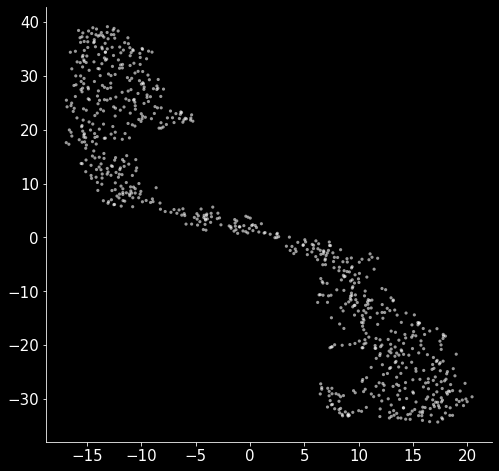

In [10]:
plt.figure(figsize=(8,8))
# cluster_ids = sorted(np.unique(clusters))
# cluster_means = np.array([np.mean(features_embedded[clusters == cluster_id], axis=0)
#                           for cluster_id in cluster_ids])

# n_clusters = len(cluster_ids)
# jet_colors = cm.plasma(np.linspace(0, 1, n_clusters))
plt.scatter(features_embedded[:, 0], features_embedded[:, 1], alpha=.6, c="w", edgecolors="none", s=10)
# adjust tubelets > take less frames as input

# video classification

In [5]:
import os
import shutil
import glob

copy_files = False
source_dir = '/Users/mikehemberger/Documents/vscode/totems/totem-prototype/roboflow-downloads/totem-prototype.v1i.yolov7pytorch'
target_dir = "./totem-prototype/videos/MVI_7423_pulse_wabbern-cropped/"
os.makedirs(os.path.join(target_dir, "images/renamed/"), exist_ok=True)
z_fill_ = 4
if copy_files:
    os.makedirs(target_dir, exist_ok=True)
    prefix = "MVI_7423_pulse_wabbern-cropped_mp4-"
    # Find all jpg and txt files in the source directory and its subdirectories
    for filename in glob.glob(source_dir + '/**/*.jpg', recursive=True):
        if os.path.basename(filename).startswith(prefix):
            renamed = str(os.path.basename(filename).split(prefix)[1].split("_jpg")[0]).zfill(z_fill_) # .split(prefix)[1]
            renamed_filename = "frame_" + renamed + ".jpg"
            destination = os.path.join(target_dir, "images/renamed/", renamed_filename)
            shutil.copyfile(filename, destination)

    for filename in glob.glob(source_dir + '/**/*.txt', recursive=True):
        if os.path.basename(filename).startswith(prefix):
            renamed = str(os.path.basename(filename).split(prefix)[1].split("_jpg")[0]).zfill(z_fill_) # .split(prefix)[1]
            renamed_filename = "frame_" + renamed + ".txt"
            destination = os.path.join(target_dir, "images/renamed/", renamed_filename)
            shutil.copyfile(filename, destination)


In [6]:
target_dir = os.path.join(target_dir, "images/renamed/")
filenames = sorted([f for f in os.listdir(target_dir) if f.endswith(".jpg")])
target_fpaths = [os.path.join(target_dir, f) for f in os.listdir(target_dir) if f.endswith(".jpg")]

df = pd.DataFrame(columns=["filename", "frame_idx", "frame_sec", "filepath", "cutout_fpath", "frame_str", "frame_int"])
sr = 40  # sampling rate
df["filename"] = filenames
df["frame_idx"] = [int(n) for n in range(len(df))]
df["frame_sec"] = df["frame_idx"] * sr  # 25hz, 40ms sr
df["filepath"] = target_fpaths
df["frame_int"] = [int(fn.split("frame_")[-1].split(".jpg")[0]) for fn in df["filename"].tolist()] #  .astype("int64")
#df.to_csv("./prototypev1.csv", index=False)
len(df)

805

In [12]:
df = pd.read_csv("../totems/prototypev1.csv")
T_idx = df["frame_idx"].max()

df = df.sort_values(by="frame_idx")

df["filepath_txt"] = sorted(df["filepath"].str.replace(".jpg", ".txt"))
df["ori_filepath"] = sorted(df["filepath"].str.replace("images/renamed","images-from-av").str.replace("frame_","frame-"))
df = df.iloc[:-1]

print(len(df))
print(df["filepath_txt"].tolist()[:5])
print(df["ori_filepath"].tolist()[:5])
df.head()

804
['./totem-prototype/videos/MVI_7423_pulse_wabbern-cropped/images/renamed/frame_0000.txt', './totem-prototype/videos/MVI_7423_pulse_wabbern-cropped/images/renamed/frame_0001.txt', './totem-prototype/videos/MVI_7423_pulse_wabbern-cropped/images/renamed/frame_0002.txt', './totem-prototype/videos/MVI_7423_pulse_wabbern-cropped/images/renamed/frame_0003.txt', './totem-prototype/videos/MVI_7423_pulse_wabbern-cropped/images/renamed/frame_0004.txt']
['./totem-prototype/videos/MVI_7423_pulse_wabbern-cropped/images-from-av/frame-0000.jpg', './totem-prototype/videos/MVI_7423_pulse_wabbern-cropped/images-from-av/frame-0001.jpg', './totem-prototype/videos/MVI_7423_pulse_wabbern-cropped/images-from-av/frame-0002.jpg', './totem-prototype/videos/MVI_7423_pulse_wabbern-cropped/images-from-av/frame-0003.jpg', './totem-prototype/videos/MVI_7423_pulse_wabbern-cropped/images-from-av/frame-0004.jpg']


/var/folders/l1/s9h8bddx0mv1bqzrqffsxhp00000gn/T/ipykernel_41809/3399057814.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df["filepath_txt"] = sorted(df["filepath"].str.replace(".jpg", ".txt"))


,filename,frame_idx,frame_sec,filepath,cutout_fpath,frame_str,frame_int,filepath_txt,ori_filepath
0,frame_0000.jpg,0,0,./totem-prototype/videos/MVI_7423_pulse_wabber...,NaN,NaN,0,./totem-prototype/videos/MVI_7423_pulse_wabber...,./totem-prototype/videos/MVI_7423_pulse_wabber...
1,frame_0001.jpg,1,40,./totem-prototype/videos/MVI_7423_pulse_wabber...,NaN,NaN,1,./totem-prototype/videos/MVI_7423_pulse_wabber...,./totem-prototype/videos/MVI_7423_pulse_wabber...
2,frame_0002.jpg,2,80,./totem-prototype/videos/MVI_7423_pulse_wabber...,NaN,NaN,2,./totem-prototype/videos/MVI_7423_pulse_wabber...,./totem-prototype/videos/MVI_7423_pulse_wabber...
3,frame_0003.jpg,3,120,./totem-prototype/videos/MVI_7423_pulse_wabber...,NaN,NaN,3,./totem-prototype/videos/MVI_7423_pulse_wabber...,./totem-prototype/videos/MVI_7423_pulse_wabber...
4,frame_0004.jpg,4,160,./totem-prototype/videos/MVI_7423_pulse_wabber...,NaN,NaN,4,./totem-prototype/videos/MVI_7423_pulse_wabber...,./totem-prototype/videos/MVI_7423_pulse_wabber...


In [8]:
# resize
src = "./totem-prototype/videos/MVI_7423_pulse_wabbern-cropped/images/renamed/"
src_ = "./totem-prototype/videos/MVI_7423_pulse_wabbern-cropped/images-224/"
os.makedirs(src_, exist_ok=True)

filenames = sorted([f for f in os.listdir(src) if f.endswith(".jpg")])
resize = (224, 224)

# for fn in filenames:
#     img = Image.open(src+fn).resize(resize)
#     img.save(src_+fn)

# # VIDEO
# images = sorted([img for img in os.listdir(src_) if img.endswith(".jpg")])
# frame = cv2.imread(os.path.join(src_, images[0]))
# height, width, layers = frame.shape

# video = cv2.VideoWriter(src_ + 'video.avi', 0, 25, (width, height))
# for image in images:
#     video.write(cv2.imread(os.path.join(src_, image)))
# cv2.destroyAllWindows()
# video.release()
df["filename"].tolist()[:5]

['frame_0000.jpg',
 'frame_0001.jpg',
 'frame_0002.jpg',
 'frame_0003.jpg',
 'frame_0004.jpg']

In [9]:
annots = df["filepath_txt"].tolist()
filenames = df["filename"].tolist()
img_filepaths = df["ori_filepath"].tolist()

d = dict()

for idx, annot in enumerate(annots):
    im = Image.open(img_filepaths[idx])
    im_width, im_height = im.size
    with open(annot, 'r') as f:
        lines = f.read().splitlines()
        for nth, line in enumerate(lines):
            values = list(map(float, line.strip().split()))
            while values:
                class_id = int(values.pop(0))

                x_values = []
                y_values = []
                while values and len(values) >= 2:
                    x_values.append(values.pop(0))
                    y_values.append(values.pop(0))
                    x1 = int(min(x_values) * im_width)
                    y1 = int(min(y_values) * im_height)
                    x2 = int(max(x_values) * im_width)
                    y2 = int(max(y_values) * im_height)
                    #print(np.array([[x1, x2],[y1, y2]]))
                d.update({filenames[idx].split(".jpg")[0] + "_" + str(nth): np.array([[x1, x2],[y1, y2]])})#np.array((x_values, y_values))})
d        
#d['frame_0000.jpg'][1,:]

{'frame_0000_0': array([[863, 888],
        [505, 520]]),
 'frame_0000_1': array([[973, 992],
        [466, 478]]),
 'frame_0000_2': array([[1063, 1081],
        [ 462,  475]]),
 'frame_0000_3': array([[1079, 1094],
        [ 424,  447]]),
 'frame_0000_4': array([[1225, 1244],
        [ 429,  455]]),
 'frame_0000_5': array([[733, 744],
        [418, 429]]),
 'frame_0000_6': array([[594, 610],
        [407, 420]]),
 'frame_0000_7': array([[570, 593],
        [527, 547]]),
 'frame_0000_8': array([[485, 502],
        [429, 442]]),
 'frame_0000_9': array([[768, 786],
        [294, 305]]),
 'frame_0000_10': array([[711, 726],
        [303, 319]]),
 'frame_0000_11': array([[717, 736],
        [372, 384]]),
 'frame_0000_12': array([[669, 681],
        [192, 207]]),
 'frame_0000_13': array([[651, 663],
        [138, 149]]),
 'frame_0000_14': array([[584, 599],
        [130, 148]]),
 'frame_0000_15': array([[592, 601],
        [ 91, 100]]),
 'frame_0000_16': array([[306, 332],
        [355, 379

In [11]:


def get_bbox(df:dict, frame:str):
    x = df[frame][0,0], df[frame][0,1], df[frame][0,1], df[frame][0,0], df[frame][0,0]
    y = df[frame][1,0], df[frame][1,0], df[frame][1,1], df[frame][1,1], df[frame][1,0]

    return np.vstack((x,y)).T



search_list = list(d.keys()) 


means = list()
for nth in range(len(search_list)):
    search_for = f"frame_{str(nth).zfill(z_fill_)}_"#'frame_0000_'
    result_keys = [f for f in search_list if f.startswith(search_for)]

    bboxes = []
    for key in result_keys:
        means.append([np.mean(get_bbox(d, key)[:,0]), np.mean(get_bbox(d, key)[:,1])])
means
#np.array(bboxes)
    # for bbox in bboxes:
    #     plt.plot(np.mean(bbox[:,0]),np.mean(bbox[:,1]),".", color=colors[nth])
    #     plt.axis("off")


[[873.0, 511.0],
 [980.6, 470.8],
 [1070.2, 467.2],
 [1085.0, 433.2],
 [1232.6, 439.4],
 [737.4, 422.4],
 [600.4, 412.2],
 [579.2, 535.0],
 [491.8, 434.2],
 [775.2, 298.4],
 [717.0, 309.4],
 [724.6, 376.8],
 [673.8, 198.0],
 [655.8, 142.4],
 [590.0, 137.2],
 [595.6, 94.6],
 [316.4, 364.6],
 [37.2, 416.2],
 [250.0, 473.2],
 [91.4, 625.8],
 [365.8, 306.4],
 [873.0, 511.0],
 [980.6, 470.8],
 [1070.2, 467.2],
 [1085.0, 433.2],
 [1232.6, 439.4],
 [737.4, 422.4],
 [600.4, 412.2],
 [579.2, 535.0],
 [491.8, 434.2],
 [775.2, 298.4],
 [717.0, 309.4],
 [724.6, 376.8],
 [673.8, 198.0],
 [655.8, 142.4],
 [590.0, 137.2],
 [595.6, 94.6],
 [316.4, 364.6],
 [37.2, 416.2],
 [250.0, 473.2],
 [91.4, 625.8],
 [365.8, 306.4],
 [873.0, 511.0],
 [980.6, 470.8],
 [1070.2, 467.2],
 [1085.0, 433.2],
 [1232.6, 439.4],
 [737.4, 422.4],
 [600.4, 412.2],
 [579.2, 535.0],
 [491.8, 434.2],
 [775.2, 298.4],
 [717.0, 309.4],
 [724.6, 376.8],
 [673.8, 198.0],
 [655.8, 142.4],
 [590.0, 137.2],
 [595.6, 94.6],
 [316.4, 364

clusters 34


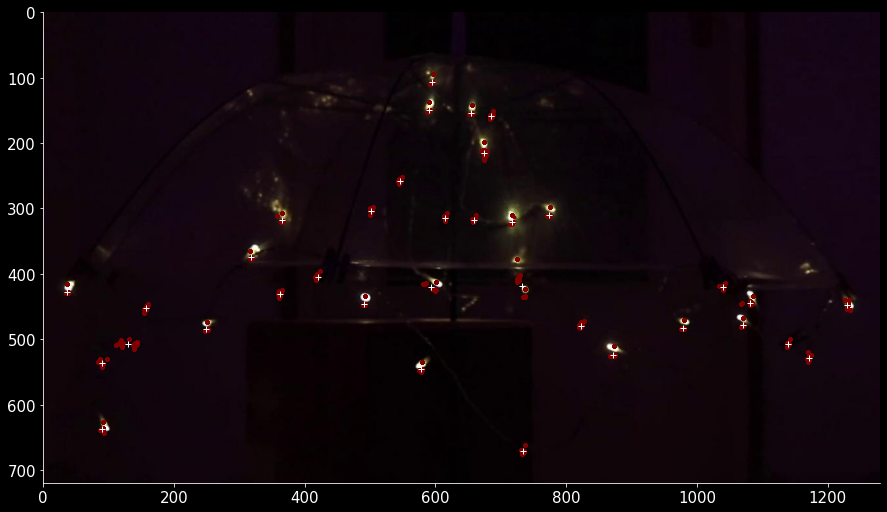

In [12]:
cmap = plt.cm.jet
colors = cmap(np.linspace(0, 1, len(search_list)))
means_ = np.array(means)
colors = cmap(np.linspace(0, 1, len(means_)))[:,:3]

plt.figure(figsize=(15,15))
plt.imshow(Image.open(df.loc[0,"ori_filepath"]))

for m in means_:
    plt.plot(m[0], m[1], ".", color=colors[nth])

from sklearn.cluster import KMeans
import numpy as np

kmeans = KMeans(n_clusters=35, random_state=0)
kmeans.fit(means_)
assignments = kmeans.labels_
centers = kmeans.cluster_centers_

print("clusters", max(assignments))

for c_ in centers:
    plt.plot(c_[0], c_[1], "+", color="w", ms=6)

# NEEDS COLORS TO TRACK CLUSERS AND VISUALIY CONFIRM time-series, plot the cluster id bsides the center

- use the cluster centers to pool nth of knn search bboxes and average them
- lastly follow them back to seg-mask

In [42]:
xoffset = 5  # in pixels from center for "temporary" bbox visialization
yoffset = 10
xframes = [int(n) for n in range(len(df))]
mat = np.zeros((len(xframes), len(centers)))
bbox_ = list()
for ith, c__ in enumerate(centers):
    x, y = c__ # centers[20]
    x_min = max(0, x - xoffset)  # make sure indices are not negative
    y_min = max(0, y - yoffset)
    x_max = x + xoffset
    y_max = y + yoffset
    for nth in xframes:
        intensity_matrix = np.array(Image.open(df.loc[nth,"ori_filepath"]))
        x_max = min(x_max, intensity_matrix.shape[1])
        y_max = min(y_max, intensity_matrix.shape[0])

        # check those boxes!!!
        # roi = intensity_matrix[int(y_min):int(y_max), int(x_min):int(x_max)]

        bbox_.append([int(y_min), int(y_max), int(x_min), int(x_max)])
        roi = intensity_matrix[int(y_min):int(y_max), int(x_min):int(x_max)]
        Image.fromarray(roi).save(f"./test/test_{ith}_{nth}.jpg")

        mat[nth, ith] = np.sum(roi)
        #mat[nth, ith] = np.mean(roi)

# slow... 4:40min:sec for 20 offset, but thats too much!

# Plot the cutouts on a black background but at their location!
- this will make it clear I hope!

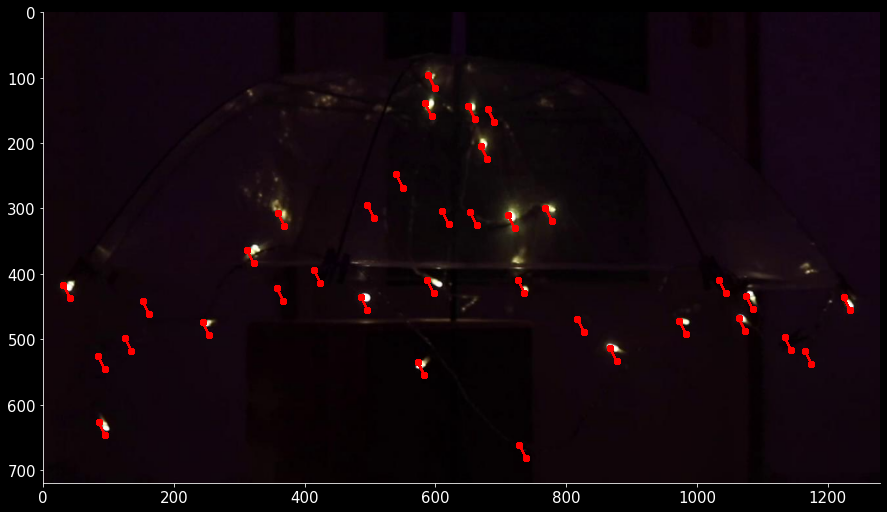

In [34]:
# PLOT IDENTIFIED ROI WITH NUMBERS, THEN USE NUMBERS TO LABEL TRACES / OR COLOR

plt.figure(figsize=(15,15))
plt.imshow(Image.open(df.loc[0,"ori_filepath"]))

for bbox in bbox_:
    plt.plot(
        [bbox[2], bbox[2], bbox[3], bbox[3], bbox[2]],
        [bbox[0], bbox[0], bbox[1], bbox[1], bbox[0]],
        "-or",)



In [ ]:
mat.max()

In [35]:
mat = pd.DataFrame(mat, columns=[f"center_{n}" for n in range(len(centers))])
mat = mat / mat.mean().mean()
mat = mat / mat.max()
#mat.max().max()
# rollingmean()

In [36]:
# take xframe 483, sorty by activity and use the sorting for visualisation
srt_idx = np.where([x == 483 for x in xframes])[0]
sorted_indices = np.argsort(mat.iloc[srt_idx, :].values)[0]
#mat.iloc[sorted_indices,:]
#sorted_indices

# Introduce Threshold red-line for .5 of normalized instensity
- also possible to set threshold at around .4 and start with a linear blue7red scale from there till 1.

In [1]:
plt.figure(figsize=(16,4))
plt.plot(xframes, np.ones(len(xframes)), "-w", lw=1)
plt.plot(xframes,mat.iloc[:, 0] / max(mat.iloc[:, 0]), "-w", lw=1)
plt.plot(xframes,mat.iloc[:, 2] / max(mat.iloc[:, 2]), "-b", lw=2)

plt.figure(figsize=(16,5))
plt.plot(xframes,mat.iloc[:, 0] / max(mat.iloc[:, 0]), "-w", lw=2)
#plt.plot(xframes,mat.iloc[:, 1] / max(mat.iloc[:, 1]), "-r", lw=2)
plt.plot(xframes,mat.iloc[:, 2] / max(mat.iloc[:, 2]), "-b", lw=2)
plt.xlim([400, 600])

plt.figure(figsize=(16,5))
plt.plot(xframes,mat.iloc[:, 0] / max(mat.iloc[:, 0]), "-w", lw=2)
#plt.plot(xframes,mat.iloc[:, 1] / max(mat.iloc[:, 1]), "-r", lw=2)
plt.plot(xframes,mat.iloc[:, 2] / max(mat.iloc[:, 2]), "-b", lw=2)
plt.xlim([450, 525])

plt.figure(figsize=(22,6.6))
plt.imshow(mat.iloc[:, sorted_indices].T, cmap="bwr")
#plt.axis("square")
plt.colorbar()
plt.xlim([450, 525])
plt.ylim([0, 35])

NameError: name 'plt' is not defined

In [ ]:
# cut out clusters and show the averGES!

In [ ]:
plt.figure(figsize=(16,12))
counter = 0
for ith in sorted_indices:
    plt.plot(xframes, counter + mat.iloc[:, ith], "-w", lw=2)
    counter += 1
    
plt.xlim([200, 600])

In [ ]:
import numpy as np

offset = 25


for center in centers:
    x, y = center
    x_min = max(0, x - offset)  # make sure indices are not negative
    y_min = max(0, y - offset)
    x_max = x + offset
    y_max = y + offset

    # Make sure indices do not exceed the array dimensions
    x_max = min(x_max, intensity_matrix.shape[1])
    y_max = min(y_max, intensity_matrix.shape[0])

    # Slice the intensity matrix to get the bounding box
    roi = intensity_matrix[int(y_min):int(y_max), int(x_min):int(x_max)]
    
    # Compute the integrated intensity
    integrated_intensity = np.sum(roi)
    print(f"Integrated intensity for center ({x},{y}): {integrated_intensity}")


# if i want to use this i have to loop across bboxes and across frames! then compare across frames, not internally

In [ ]:
all = np.array(())
all_ = dict()

for n in range(5):
    bbox_0 = bboxes_frames[int(n)+1]
    bbox_1 = bboxes_frames[int(n)+2]
    ious = list()

    for bbox in bbox_0:
        entries = [calculate_iou(bbox, bbox_) == 1. for bbox_ in bbox_1] #len(np.unique([calculate_iou(bbox, bbox_) for bbox_ in bbox_1]))
        if sum(entries) > 1:
            print(sum(entries))
            ious.append(np.where(entries))
    if ious:  
        all = np.concatenate(ious)
        all = all[all>0]
        all_[int(n)] = all

all_

In [ ]:

xbins = np.arange(0, 1, step=0.1)
c, bins = np.histogram(all_[2], xbins)
c_, bins_ = np.histogram(all_[3], xbins)

plt.figure()
plt.plot(bins[:-1], c,'-w')
plt.plot(bins_[:-1], c_,'-r')

In [ ]:
ious_ = dict()

for ith, bboxes in bboxes_frames.items():
    ious = list()
    for nth in range(len(bboxes)):
        if len(np.unique([calculate_iou(bboxes[nth], bbox) for bbox in bboxes])) > 2:
            ious.append(np.unique([calculate_iou(bboxes[nth], bbox) for bbox in bboxes]))
    
    ious_[ith] = ious
    # have to carry index over somehow

In [ ]:
np.unique(ious[3])

all_ = list()
for i, val in ious_.items():
    for le in val:
        #print(le[(le > 0) & (le < 1)])
        all_.append(le[(le > 0) & (le < 1)])

all_
all = np.concatenate(all_)

xbins = np.arange(0, 1, step=0.1)
c, bins = np.histogram(all, xbins)

plt.figure()
plt.bar(bins[:-1], c, width=.1)

# Try to find across frames first!

In [ ]:

search_list = list(d.keys()) 
colors = ["w", "g", "y"]

plt.figure()
#plt.imshow(Image.open(df.loc[0,"filepath"]))

for nth in [0,1,2]:
    search_for = f"frame_{str(nth).zfill(z_fill_)}_"#'frame_0000_'
    result_keys = [f for f in search_list if f.startswith(search_for)]

    bboxes = []
    for key in result_keys:
        bboxes.append(get_bbox(d, key))

    for bbox in bboxes:
        plt.plot(bbox[:,0],bbox[:,1],"-", color=colors[nth])

In [ ]:
ious = dict()

for nth in range(len(bboxes)):
    iou = [calculate_iou(bboxes[nth], bbox) for bbox]

    ious.append(np.unique(iou))

ious

In [ ]:
from skimage.draw import polygon

def coords_to_mask(coords, shape):
    """
    Erstellt eine binäre Maske von einer Liste von Koordinaten.
    """
    mask = np.zeros(shape, dtype=np.uint8)
    rr, cc = polygon(coords[:,1], coords[:,0])  # x, y vertauschen
    mask[rr, cc] = 1
    return mask


def calculate_iou(coords1, coords2):
    """
    Berechnet die Intersection over Union (IoU) zwischen zwei Listen von Koordinaten.
    Bestimmt die Form basierend auf den maximalen x- und y-Koordinaten.
    """
    max_coord = np.maximum(coords1.max(axis=0), coords2.max(axis=0))
    shape = np.ceil(max_coord[::-1] + 1 + 10).astype(int)  # x, y vertauschen und einen Puffer von 10 hinzufügen

    mask1 = coords_to_mask(coords1, shape)
    mask2 = coords_to_mask(coords2, shape)

    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    
    if np.sum(union) == 0:
        return 0.0
    else:
        iou_score = np.sum(intersection) / np.sum(union)
        return iou_score




# Definiere die Koordinaten der Polygone
polygon1 = np.array([[20, 20], [30, 50], [40, 20]])
polygon2 = np.array([[30, 30], [40, 45], [50, 60], [40, 75], [30, 90], [20, 75]])
polygon3 = np.array([[60, 60], [65, 70], [70, 80], [75, 90], [80, 100], [75, 110], [70, 120], [65, 130], [60, 140]])

# Berechne die IoU zwischen den Polygonen
iou_score1 = calculate_iou(polygon1, polygon1)
iou_score2 = calculate_iou(polygon1, polygon3)
iou_score3 = calculate_iou(polygon2, polygon3)

# Drucke die IoU-Scores
print(f"IoU score between polygon1 and polygon1: {iou_score1}")
print(f"IoU score between polygon1 and polygon3: {iou_score2}")
print(f"IoU score between polygon2 and polygon3: {iou_score3}")
print(polygon1.shape, polygon2.shape)

In [ ]:
plt.plot(polygon1[:,0], polygon1[:,1])
plt.plot(polygon2[:,0], polygon2[:,1], "-b.")
plt.plot(polygon3[:,0], polygon3[:,1], "-r.")

In [ ]:
from transformers import ViTFeatureExtractor, ViTModel
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')  # 244-in21k
model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k', return_dict=True)  # 224-in21k

filenames = df["filename"].tolist()
feature_vectors = []
for i, image in enumerate(filenames): 
    image = Image.open(src_+image)
    inputs = feature_extractor(images=image, return_tensors="pt")
    outputs = model(**inputs)
    feature_vector = outputs.pooler_output.detach().cpu().numpy()
    feature_vectors.append(feature_vector)

feature_vectors = np.concatenate(feature_vectors, axis=0)
#np.save(os.path.join(src_,"prototypev1-fv-MVI_7423_pulse_wabbern-cropped-224.npy"), feature_vectors)

print(feature_vectors.shape)

In [ ]:
fv = np.load(src_ + "prototypev1-fv-MVI_7423_pulse_wabbern-cropped-224.npy")

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=65, early_exaggeration=220, learning_rate=45, random_state=42, init="pca")
features_embedded = tsne.fit_transform(fv)

plt.figure(figsize=(7,7))
plt.scatter(features_embedded[:, 0], features_embedded[:, 1], color="w", alpha=.5, edgecolors="none", s=30)
plt.axis("square")

In [ ]:
cluster_idx

In [ ]:
filter_x = [(-25, 5), (5.05, 15)]
cluster_idx = []
col = ["w", "r"]
plt.figure()
for nth, (filt, c) in enumerate(zip(filter_x, col)):
    cidx = (features_embedded[:, 0] > filt[0]) & (features_embedded[:, 0] < filt[1])
    cluster_idx.append(np.where(cidx)[0])
    plt.scatter(features_embedded[cidx, 0], features_embedded[cidx, 1], color=c, alpha=.5, edgecolors="none", s=30)
    plt.axis("square")


# VIDEO
filenames = df["filename"].tolist()
for nth, cid in enumerate(cluster_idx):
    cfilenames = np.array(filenames)[cid]
    frame = cv2.imread(os.path.join(src_, cfilenames[0]))
    height, width, layers = frame.shape

    video = cv2.VideoWriter(src_ + f'video_{nth}.avi', 0, 25, (width, height))
    for image in cfilenames:
        video.write(cv2.imread(os.path.join(src_, image)))
    cv2.destroyAllWindows()
    video.release()


# Get all annotation files and extract all seg masks / or transfered to bbox
- Thrn use IoU to determine which LEDs overlap, visualize and recheck
- set a threshold on IoU to merge LEDs together and stick with that final set of LEDs over all frames!!!
- then integrate, mean, area-normalize integrated intensity values from images / bbox cut outs

- HAS TO BE DONE ON ORIGINAL EXTRACTED IMAGES AND TXT ANNOTATIONS

In [ ]:
# Importiere die notwendigen Bibliotheken
import numpy as np
from skimage.draw import polygon

# Definiere die Funktionen zur Erstellung der Maske und zur Berechnung der IoU
def coords_to_mask(coords, shape):
    """
    Erstellt eine binäre Maske von einer Liste von Koordinaten.
    """
    mask = np.zeros(shape, dtype=np.uint8)
    rr, cc = polygon(coords[:,0], coords[:,1])
    mask[rr, cc] = 1
    return mask

def calculate_iou(coords1, coords2, shape):
    """
    Berechnet die Intersection over Union (IoU) zwischen zwei Listen von Koordinaten.
    """
    mask1 = coords_to_mask(coords1, shape)
    mask2 = coords_to_mask(coords2, shape)
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

# Definiere die Koordinaten der Polygone
polygon1 = np.array([[20, 20], [30, 50], [40, 20]])
polygon2 = np.array([[30, 30], [40, 60], [50, 30]])
polygon3 = np.array([[60, 60], [70, 80], [80, 60]])

# Berechne die IoU zwischen den Polygonen
iou_score1 = calculate_iou(polygon1, polygon2, (100, 100))
iou_score2 = calculate_iou(polygon1, polygon3, (100, 100))
iou_score3 = calculate_iou(polygon2, polygon3, (100, 100))

# Drucke die IoU-Scores
print(f"IoU score between polygon1 and polygon2: {iou_score1}")
print(f"IoU score between polygon1 and polygon3: {iou_score2}")
print(f"IoU score between polygon2 and polygon3: {iou_score3}")


In [ ]:
#target_dir = "./totem-prototype/videos/MVI_7423_pulse_wabbern-cropped/"
#os.makedirs(os.path.join(target_dir, "images/renamed/"), exist_ok=True)

# load all annot files and structure data


# for vis_class in num_vis_classes:
#     frames = df_["filename"].tolist()  # sorted([f for f in os.listdir(image_dir) if f.endswith(".jpg")])
#     annots = df_["filename"].str.replace(".jpg", ".txt")#.tolist()  #sorted([f for f in os.listdir(image_dir) if f.endswith(".txt")])


In [ ]:
target_dir = "./totem-prototype/videos/MVI_7423_pulse_wabbern-cropped/"
os.makedirs(os.path.join(target_dir, "images/renamed/"), exist_ok=True)

In [ ]:

target_dir = "./totem-prototype/videos/MVI_7423_pulse_wabbern-cropped/"

# Specify the classes
num_vis_classes = ["0"]  # Add or remove class ids here
#os.makedirs(os.path.join(target_dir, f"cutout-bbox-class{0}/"), exist_ok=True)

# Specify your directories
image_dir = os.path.join(target_dir, "images/renamed/")

for vis_class in num_vis_classes:
    frames = df_["filename"].tolist()  # sorted([f for f in os.listdir(image_dir) if f.endswith(".jpg")])
    annots = df_["filename"].str.replace(".jpg", ".txt")#.tolist()  #sorted([f for f in os.listdir(image_dir) if f.endswith(".txt")])

    # Print the number of images and annotations found
    print(f"Found {len(frames)} frames and {len(annots)} annotation files.",
          f"{frames[:4]},{annots[:4]}")

    #Iterate through the images and annotations
    for idx, frame in enumerate(frames):
        im = Image.open(os.path.join(image_dir, frame))
        im_width, im_height = im.size  # Image dimensions

        with open(os.path.join(image_dir, annots[idx]), 'r') as f:
            lines = f.read().splitlines()
            for nth, line in enumerate(lines):
                # Split the line into a list of values
                values = list(map(float, line.strip().split()))
                # Extract and process each class separately
                while values:
                    # Get the class ID and remove it from the list
                    class_id = int(values.pop(0))
                    # Only process the specified classes
                    if str(class_id) not in num_vis_classes:
                        break

                    # Calculate the bounding box coordinates from the segmentation mask
                    x_values = []
                    y_values = []
                    while values and len(values) >= 2:
                        x_values.append(values.pop(0))
                        y_values.append(values.pop(0))
                    x1 = int(min(x_values) * im_width)
                    y1 = int(min(y_values) * im_height)
                    x2 = int(max(x_values) * im_width)
                    y2 = int(max(y_values) * im_height)

                    # Extract and save the bounding box as a separate image
                    bbox_image = im.crop((x1, y1, x2, y2))
                    os.makedirs(os.path.join(target_dir, f"cutout-bbox-class{nth}/"), exist_ok=True)
                    bbox_image.save(os.path.join(target_dir, f"cutout-bbox-class{nth}/" + frame), "JPEG", quality=95)

    # for idx, frame in enumerate(frames):
    #         im = Image.open(os.path.join(image_dir, frame))
    #         im_width, im_height = im.size  # Image dimensions
    #         with open(os.path.join(image_dir, annots[idx]), 'r') as f:
    #             for _, line in enumerate(f):
    #                 #print(line.strip().split()[0])
    #                 if int(line.strip().split()[0]) == int(vis_class):
    #                     print(int(line.strip().split()[0]))
    #                     print(len(line.strip().split()), frame)
    #                     class_id, x_center, y_center, width, height = map(float, line.strip().split())
    #                     class_id = int(class_id)
            
    #                     x1 = int((x_center - width / 2.) * im_width)
    #                     y1 = int((y_center - height / 2.) * im_height)
    #                     x2 = int((x_center + width / 2.) * im_width)
    #                     y2 = int((y_center + height / 2.) * im_height)

    #                     # Extract and save the bounding box as a separate image
    #                     bbox_image = im.crop((x1, y1, x2, y2))
                            #bbox_image = bbox_image.resize((224,224))
                            #bbox_image.save(f"./data/videos/fusion-2014/class{vis_class}-video/{os.path.basename(frame).replace('.jpg', '')}.jpg", "JPEG", quality=95)

                            # Save the image
                        #bbox_image.save(os.path.join("./data/videos/VID-20230703-WA0028/annotated-roboflow-v12/images/", f"cutout-bbox-class{class_id}/frame_{str(idx).zfill(3)}.jpg"), "JPEG", quality=95)
